In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import louvain_communities
import networkx.algorithms.community

## Functions

In [ ]:
def modularity(G, communities):

    '''For undirected graphs'''

    Q = 0
    m = G.number_of_edges()
    
    for community in communities:
        subgraph = G.subgraph(community)
        L_c=subgraph.number_of_edges()         
        k_c=sum(dict(G.degree(community)).values())  
        
        Q+=(L_c/m)-(k_c/(2*m))**2

    return Q

def assortivity_coeff(G,communities):

    '''For undirected graphs'''

    Q = 0
    m = G.number_of_edges()
    Q_max=1
    
    for community in communities:
        subgraph = G.subgraph(community)
        L_c=subgraph.number_of_edges()         
        k_c=sum(dict(G.degree(community)).values())  
        
        Q+=(L_c/m)-(k_c/(2*m))**2
        Q_max-=(k_c/(2*m))**2
         
    return Q/Q_max

## Loading Graph

In [15]:
# Load the graph
G = nx.read_edgelist("com-amazon.ungraph.txt",nodetype=int)

In [16]:
nx.number_connected_components(G)

1

In [17]:
# pos = nx.spring_layout(G,seed=42)

# plt.figure(figsize=(8, 6))
# nx.draw(G, pos,
#         node_size=10,
#         cmap=plt.cm.tab10,
#         edge_color='gray')
# plt.title("Network")
# plt.show()

## Louvain Method

In [18]:
louvain_communities=networkx.algorithms.community.louvain_communities(G)
node_community = {}

for i, comm in enumerate(louvain_communities):
    for node in comm:
        node_community[node] = i


In [ ]:
largest_community=G.subgraph(max(louvain_communities,key=len))

In [20]:
print("Louvain Communities")
print("Number of communities:",len(louvain_communities))
print(modularity(G,louvain_communities))
print(assortivity_coeff(G,louvain_communities))
print()


Louvain Communities
Number of communities: 232
0.9259467243036136
0.9401956579037909



In [21]:
communities = []

with open('com-amazon.all.dedup.cmty.txt', 'r') as f:
    for line in f:
        community = set(map(int, line.strip().split()))
        communities.append(community)

print(len(communities))

75149


In [22]:
seen = set()
duplicates = set()

for comm in communities:
    for node in comm:
        if node in seen:
            duplicates.add(node)
        else:
            seen.add(node)

print(f"Number of duplicated nodes: {len(duplicates)}")
print("Some examples:", list(duplicates)[:10])


Number of duplicated nodes: 301594
Some examples: [524288, 1, 2, 524290, 4, 5, 524294, 524295, 524296, 524289]


In [23]:
union = set()

for comm in communities:
    union.update(comm)

missing_nodes = set(G.nodes) - union
print("Missing nodes:", missing_nodes)

if len(union) == len(G.nodes):
    print("WOOOOOOO")
else:
    print("Some nodes are NOT in any community.")


Missing nodes: {32768, 229377, 65543, 131079, 294922, 360467, 360469, 524309, 229399, 131096, 327703, 327704, 98331, 65564, 491547, 32798, 393247, 131104, 458782, 360483, 458787, 426021, 229415, 327721, 393257, 163884, 491564, 229424, 49, 360497, 426037, 196663, 360503, 196665, 229434, 524346, 294972, 524347, 327742, 393279, 262209, 426051, 68, 294982, 163912, 327752, 98382, 229458, 229461, 294997, 458842, 98396, 98397, 196702, 426078, 196704, 229472, 131170, 163939, 360545, 393315, 327786, 65644, 458860, 327790, 113, 131186, 163960, 131197, 32894, 295037, 327805, 65665, 426109, 426113, 295044, 458880, 524417, 131207, 524422, 426121, 229514, 229516, 262285, 32913, 163985, 393361, 65686, 98455, 458903, 196763, 426140, 98461, 458907, 262305, 393378, 524452, 458917, 295078, 458920, 295083, 491692, 196781, 32944, 131250, 458935, 65725, 295101, 360638, 229568, 327873, 426176, 458943, 196, 491710, 524479, 360650, 426188, 327885, 426193, 32978, 229587, 360658, 426195, 393430, 229591, 196824, 

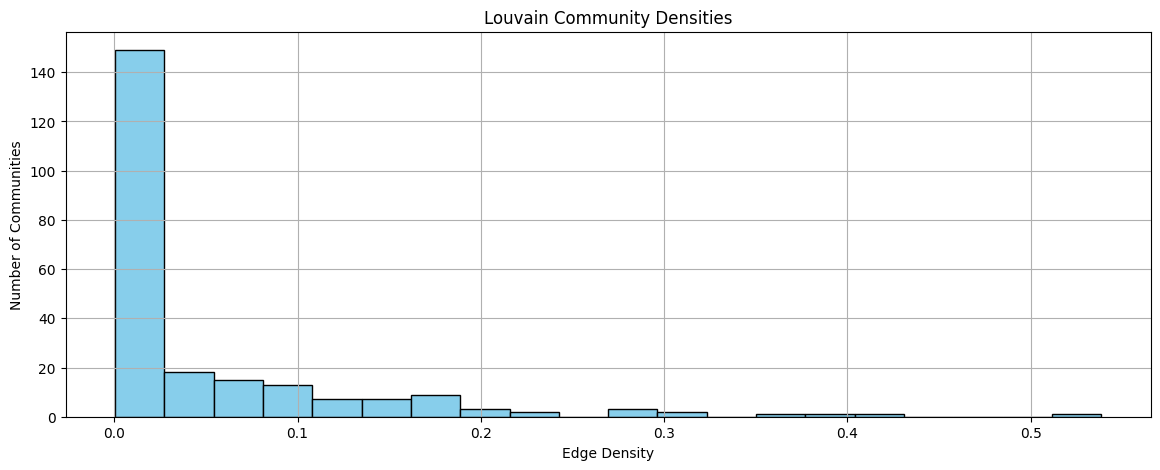

In [24]:
def get_edge_densities(G, communities):
    densities = []
    for c in communities:
        subG = G.subgraph(c)
        n = subG.number_of_nodes()
        e = subG.number_of_edges()
        if n > 1:
            density = 2 * e / (n * (n - 1))
            densities.append(density)
        else:
            densities.append(0)  # handle singleton community
    return densities

# Compute densities
louvain_densities = get_edge_densities(G, louvain_communities)

# Plotting with plt.subplot
plt.figure(figsize=(14, 5))

# Louvain plot
plt.hist(louvain_densities, bins=20, color='skyblue', edgecolor='black')
plt.title('Louvain Community Densities')
plt.xlabel('Edge Density')
plt.ylabel('Number of Communities')
plt.grid(True)

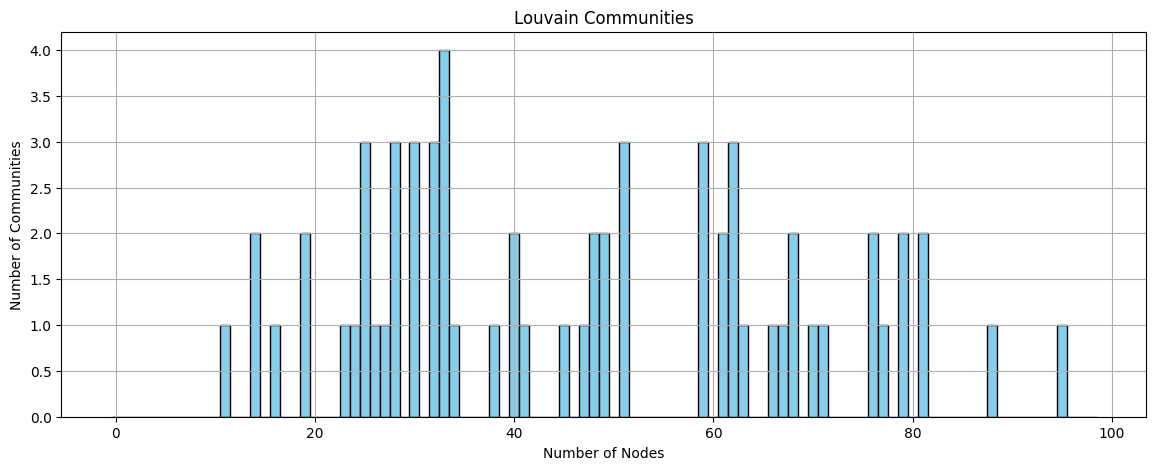

In [30]:
# Get node counts per community
louvain_node_counts = [len(comm) for comm in louvain_communities]

# Set bins so each bin represents 1 node
max_nodes = max(louvain_node_counts, default=0)
bins = range(0, 100)

# Plotting
plt.figure(figsize=(14, 5))
plt.hist(louvain_node_counts, bins=bins, color='skyblue', edgecolor='black', align='left')
plt.title('Louvain Communities')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Communities')
plt.grid(True)


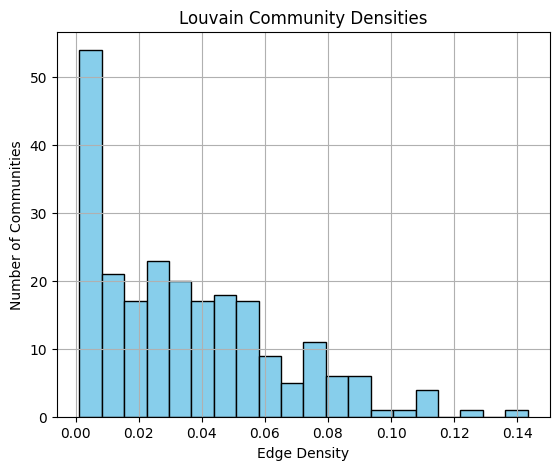

In [27]:
def external_edge_densities(G, communities):
    densities = []
    for c in communities:
        if len(c) <= 1:
            densities.append(0.0)
            continue
        total_deg = sum(dict(G.degree(c)).values())
        internal_deg = sum(dict(G.subgraph(c).degree()).values())
        if total_deg == 0:
            densities.append(0.0)
        else:
            external_fraction = (total_deg - internal_deg) / total_deg
            densities.append(external_fraction)
    return densities

# Compute densities
louvain_densities = external_edge_densities(G, louvain_communities)

# Plotting with plt.subplot
plt.figure(figsize=(14, 5))

# Louvain plot
plt.subplot(1, 2, 1)
plt.hist(louvain_densities, bins=20, color='skyblue', edgecolor='black')
plt.title('Louvain Community Densities')
plt.xlabel('Edge Density')
plt.ylabel('Number of Communities')
plt.grid(True)